<a href="https://colab.research.google.com/github/CristhianPozo1996/practicas-finales-ml-u3-u4/blob/main/Random_Forests_Cristhian_Pozo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A fondo: Árboles de decisión y Bosques Aleatorios (Random Forests)

Antes ya hemos estudiado dos tipos distintos de clasificadores:

Uno generativo, como Naive Bayes.

Y uno discriminativo más avanzado, como Support Vector Machines.

Ahora vamos a explorar otro algoritmo muy utilizado y bastante poderoso llamado Random Forest (o Bosque Aleatorio). Este tipo de modelo pertenece a los llamados métodos de ensamble, lo que significa que en lugar de usar solo un modelo, combina los resultados de varios modelos más simples para tomar una decisión final.

La idea principal es que muchas opiniones juntas pueden ser más precisas que una sola opinión individual. Es decir, si varios modelos votan para decidir una clasificación, el resultado conjunto puede ser mejor que el de cualquiera de ellos por separado. Más adelante veremos ejemplos de esto.

In [22]:
!pip install seaborn
import seaborn as sns

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")

Comencemos con Árboles de Decisión

Random Forest está construido a partir de muchos árboles de decisión, por eso primero es importante entender cómo funciona un árbol de decisión.

Un árbol de decisión es un método muy intuitivo para clasificar cosas. Básicamente, se trata de hacer una serie de preguntas para ir descartando opciones hasta llegar a una respuesta final.
Por ejemplo: si quisieras identificar qué animal estás viendo durante una caminata, podrías seguir un árbol que pregunta cosas como:

¿Tiene pelo?

¿Vuela o camina?

¿Es grande o pequeño?

Cada pregunta te ayuda a descartar parte de las opciones y acercarte a la respuesta correcta.

Esto funciona muy bien porque cada pregunta divide el conjunto de opciones en dos partes, lo que reduce rápidamente el número de posibles respuestas. El reto está en elegir las preguntas correctas, ya que una buena pregunta divide la información de forma equilibrada.

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.08-decision-tree.png?raw=1)
[figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Decision-Tree-Example)

En Machine Learning, estas "preguntas" se transforman en cortes dentro los datos basados en sus características. Cada nodo del árbol separa la información en dos grupos según un valor límite de alguna variable.

A continuación veremos un ejemplo para entenderlo mejor.

### Creando un Árbol de Decisión

Imagina que tenemos un conjunto de datos con dos características (es decir, datos que podemos dibujar en un plano con eje X y eje Y). Cada punto pertenece a una de cuatro posibles clases o categorías, como puedes ver en la figura que se muestra a continuación.

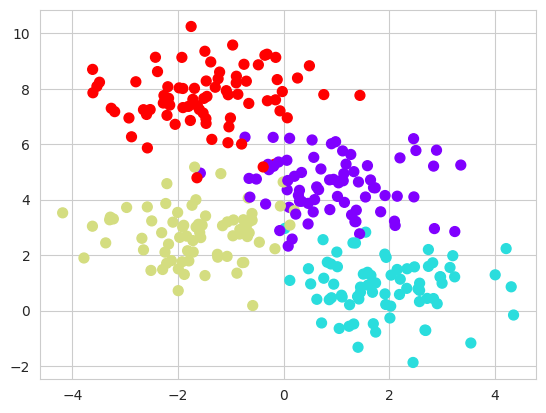

In [24]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

Un árbol de decisión simple construido con estos datos irá dividiendo los puntos poco a poco, haciendo cortes ya sea en el eje X o en el eje Y, basándose en algún criterio numérico (por ejemplo, dónde separar para que los grupos queden más ordenados).

En cada división o nivel del árbol, la nueva región formada recibe la etiqueta que sea más común entre los puntos que quedan dentro de ella, es decir, se asigna la clase por votación mayoritaria.

La siguiente figura muestra cómo se ven las primeras cuatro divisiones (o niveles) que realiza el árbol de decisión para este conjunto de datos.

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.08-decision-tree-levels.png?raw=1)
[figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Decision-Tree-Levels)

Observa que después del primer corte, todos los puntos que quedan en la rama superior ya quedan correctamente agrupados desde el inicio. Por eso, no es necesario seguir dividiendo esa parte del árbol.

Excepto en los nodos donde todos los puntos son de un solo color (es decir, ya pertenecen a la misma clase y no necesitan más trabajo), en cada nivel del árbol todas las regiones que aún contienen mezcla de puntos se vuelven a dividir, eligiendo nuevamente un valor de alguna de las dos características para separarlos.

Este proceso de construir y ajustar un árbol de decisión con nuestros datos puede realizarse…

In [25]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

Vamos a escribir una función auxiliar que nos permita visualizar el resultado del clasificador:

In [26]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()

    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

Ahora podemos observar cómo se ve la clasificación realizada por el árbol de decisión (ver la figura mostrada a continuación):

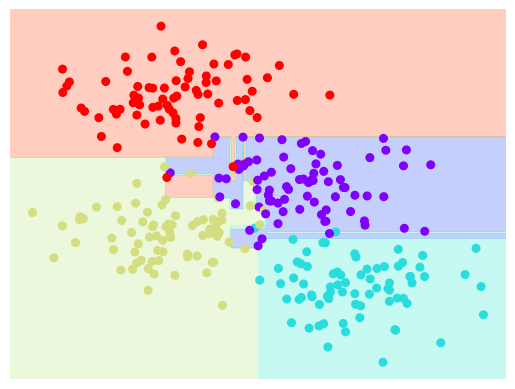

In [27]:
visualize_classifier(DecisionTreeClassifier(), X, y)

In [28]:

import helpers
helpers.plot_tree_interactive(X, y);

interactive(children=(IntSlider(value=5, description='depth', max=5, min=1), Output()), _dom_classes=('widget-…

Observa que, a medida que el árbol crece y aumentamos su profundidad, las regiones que crea para clasificar los datos empiezan a tener formas muy extrañas.
Por ejemplo, con una profundidad de cinco niveles aparece una región morada muy alargada y delgada entre las zonas amarilla y azul.

Es evidente que esa forma no representa realmente cómo están distribuidos los datos en la realidad, sino que es más bien consecuencia del ruido o la forma exacta en que se tomaron las muestras. Dicho de otra manera, este árbol de decisión —aun con solo cinco niveles— está aprendiendo demasiado los detalles específicos del conjunto de datos, incluyendo errores o variaciones que no representan un patrón real.

Eso significa que el modelo está sobreajustando (overfitting): está memorizando los datos en lugar de generalizar correctamente.

### Árboles de Decisión y Overfitting

El problema del sobreajuste (overfitting) es algo muy común en los árboles de decisión. Es muy fácil hacer que el árbol crezca demasiado y termine aprendiendo detalles específicos del conjunto de datos, en lugar de captar patrones generales que se puedan aplicar a datos nuevos.

Una manera de ver claramente este sobreajuste es entrenar el modelo usando solo una parte de los datos y compararlo con otro árbol entrenado con una parte distinta. Por ejemplo, en la figura se muestran dos árboles diferentes: cada uno se entrenó con la mitad del conjunto original.

Al comparar las regiones que generan, se puede notar que cada árbol produce divisiones diferentes y muy detalladas, lo cual es una señal de que están aprendiendo cosas demasiado específicas de los datos que recibieron, y no un patrón general.

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.08-decision-tree-overfitting.png?raw=1)
[figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Decision-Tree-Overfitting)

Es evidente que en algunas zonas los dos árboles coinciden en sus resultados (por ejemplo, en las cuatro esquinas del gráfico), pero en otras partes sus clasificaciones son muy diferentes (especialmente en las áreas que están entre dos grupos de puntos).

Lo importante aquí es notar que esas diferencias aparecen principalmente en las zonas donde la clasificación no es tan clara. Y esto nos lleva a una idea interesante: si combinamos la información de ambos árboles, podríamos obtener una clasificación más estable y con mejores resultados.

Si estás ejecutando este notebook de manera interactiva, la siguiente función te permitirá visualizar cómo se ajustan los árboles entrenados usando subconjuntos aleatorios de los datos.

In [29]:
# helpers_05_08 is found in the online appendix
import helpers
helpers.randomized_tree_interactive(X, y)

interactive(children=(IntSlider(value=0, description='random_state'), Output()), _dom_classes=('widget-interac…

Así como combinar la información de dos árboles mejora nuestros resultados, podríamos esperar que utilizar la información de muchos árboles mejore aún más el desempeño del modelo.

## Conjuntos de Estimadores: Random Forests

La idea principal que venimos observando es la siguiente: si varios modelos tienden a sobreajustarse por separado, combinarlos puede ayudar a reducir ese sobreajuste.
Este concepto da origen a un método conocido como bagging.

Bagging funciona utilizando un conjunto (un “bolsón” o grupo) de varios modelos que se entrenan en paralelo. Cada uno aprende de los datos por separado y puede sobreajustarse, pero al final se combinan sus resultados —normalmente promediándolos o votándolos— para obtener una clasificación más estable y precisa.

Cuando este conjunto está formado por muchos árboles de decisión construidos de manera aleatoria, a ese método se le llama Random Forest (Bosque Aleatorio).

En otras palabras:

🔹 Un solo árbol se puede equivocar o exagerar patrones.
🔹 Muchos árboles juntos, combinando resultados, producen un modelo más fuerte.
💡 Ese es el concepto de un Random Forest.

Este tipo de clasificación con bagging puede realizarse manualmente usando BaggingClassifier de Scikit-Learn, tal como se muestra aquí (ver la figura incluida en el texto).

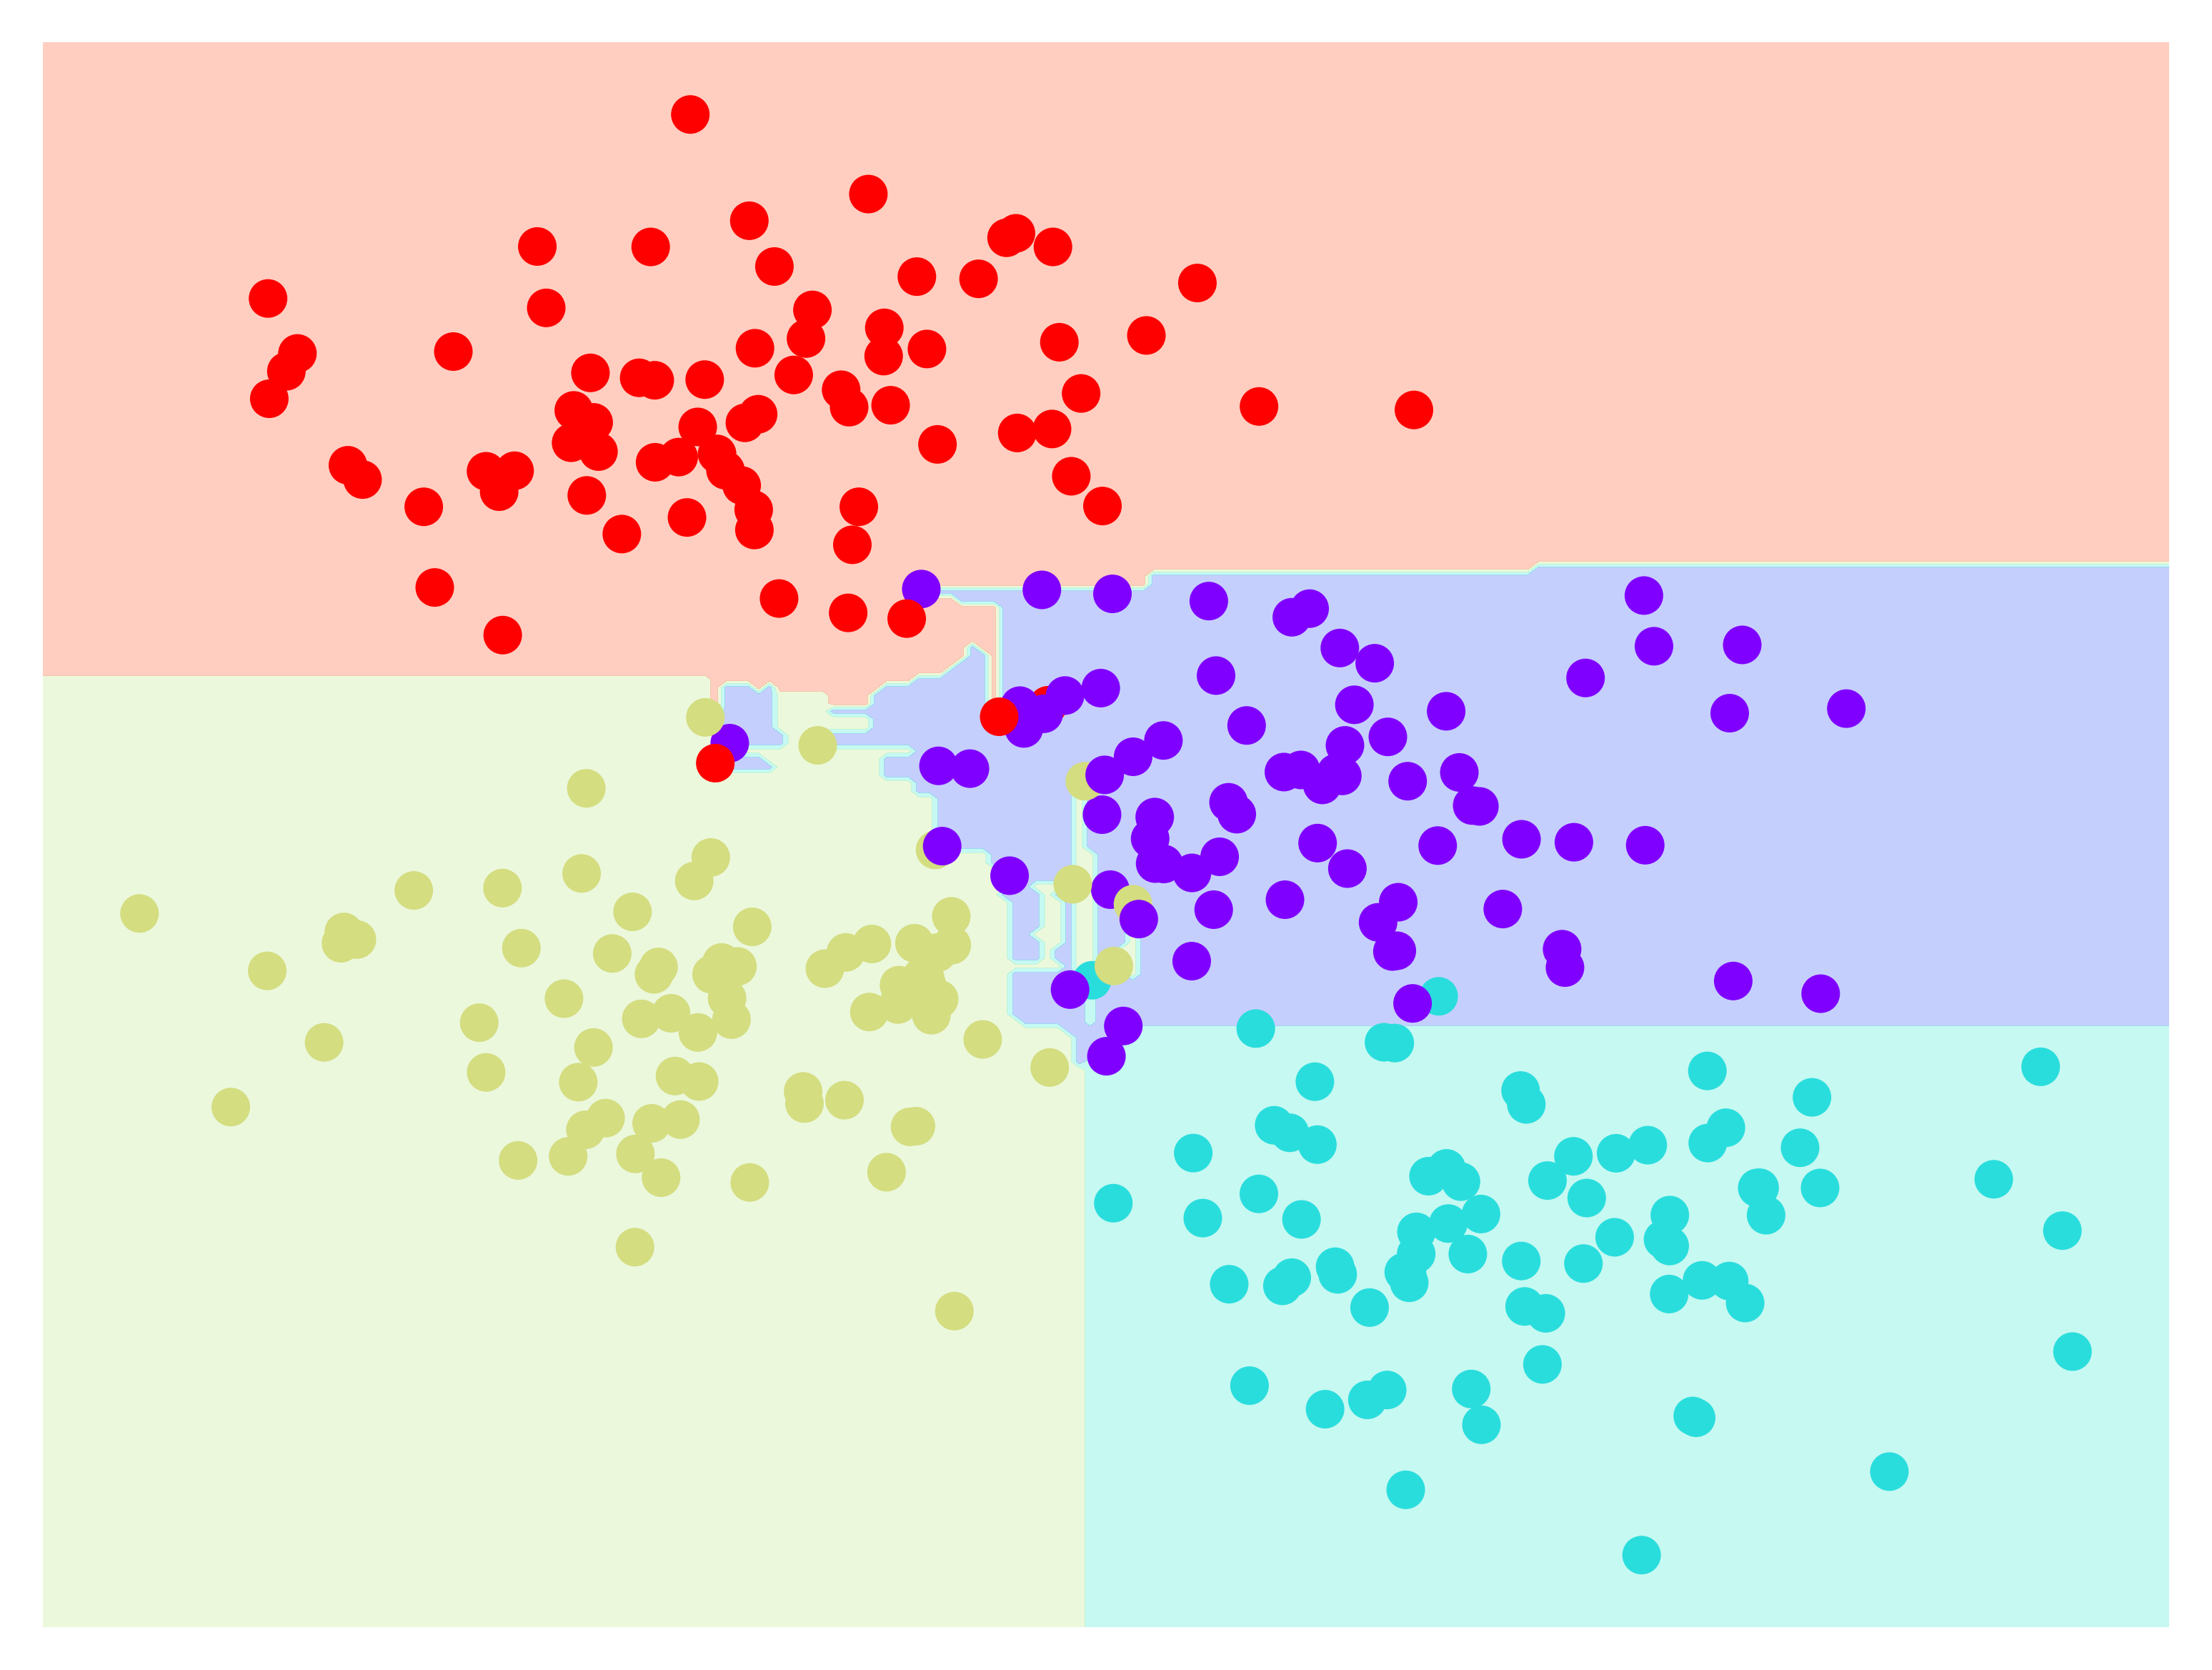

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

En este ejemplo, hemos introducido aleatoriedad en los datos entrenando cada estimador (cada árbol) con un subconjunto aleatorio que contiene el 80% de los puntos de entrenamiento.
Sin embargo, en la práctica existe [Scikit-Learn documentation](http://scikit-learn.org/stable/modules/ensemble.html#forest) una forma aún más eficiente de aleatorizar árboles de decisión: en lugar de usar diferentes subconjuntos de datos, se puede agregar azar directamente al proceso con el que cada árbol elige sus divisiones.

De esta manera, todos los datos se utilizan en cada entrenamiento, pero los árboles siguen siendo distintos entre sí, ya que las decisiones internas cambian de forma aleatoria.
Por ejemplo, cuando un árbol decide en cuál característica dividir, un árbol aleatorio puede elegir entre las mejores opciones en vez de siempre escoger la más óptima. Esto introduce suficiente variación como para que los árboles sean distintos, lo cual es clave para que el conjunto funcione bien.

Si quieres saber más detalles técnicos sobre estas formas de aleatorización, puedes consultarlo en la documentación de Scikit-Learn y las referencias que allí aparecen.

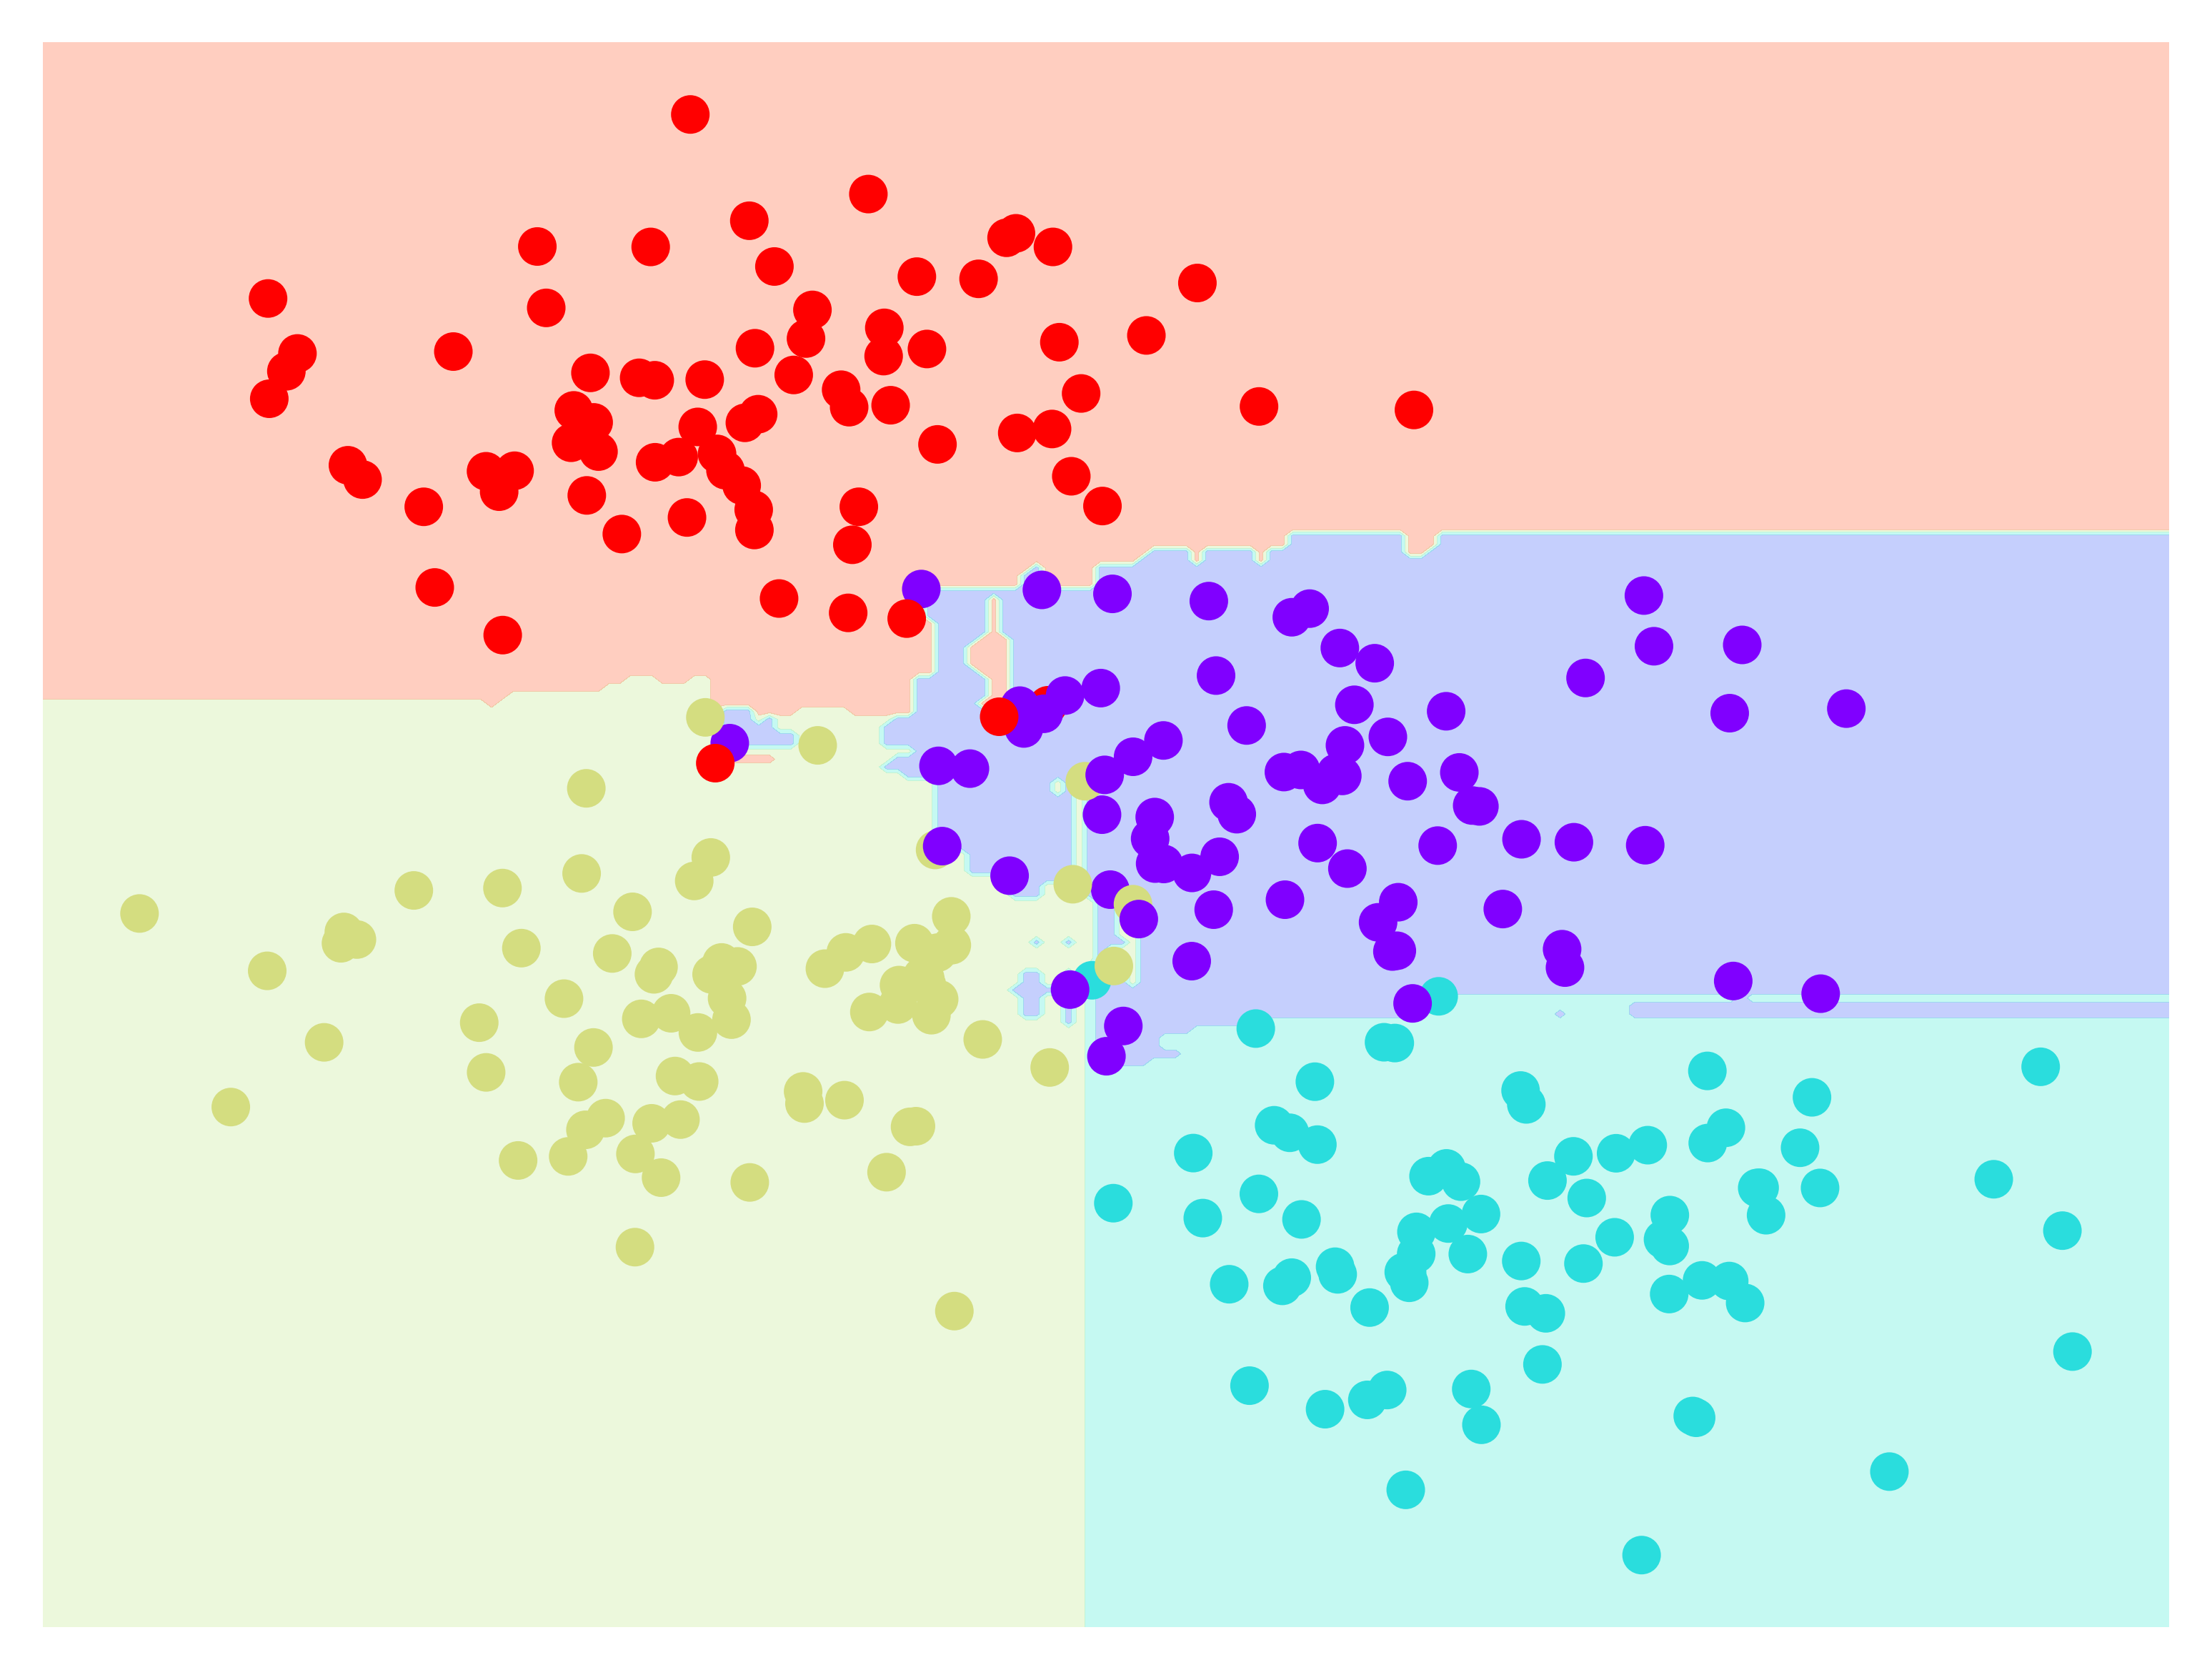

In [31]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

Al promediar los resultados de 100 modelos aleatorizados, obtenemos un resultado final que se acerca mucho más a lo que intuitivamente esperaríamos sobre cómo debería dividirse el espacio de datos.

Es decir, aunque cada árbol individual comete errores o genera divisiones poco naturales, al combinar muchos de ellos el resultado se suaviza y se vuelve más coherente, logrando una clasificación mucho más estable y lógica.

## Random Forest para Regresión

En la sección anterior analizamos los random forests aplicados a problemas de clasificación, donde las etiquetas pertenecen a categorías específicas.

Pero los random forests también pueden utilizarse para regresión, es decir, para predecir valores numéricos continuos en lugar de clases.
En este caso se utiliza el estimador RandomForestRegressor, cuyo uso y sintaxis son casi idénticos a los que ya vimos con el clasificador.

Para ilustrarlo, consideremos los siguientes datos, que provienen de la combinación de una oscilación rápida y una más lenta (como se muestra en la figura siguiente).

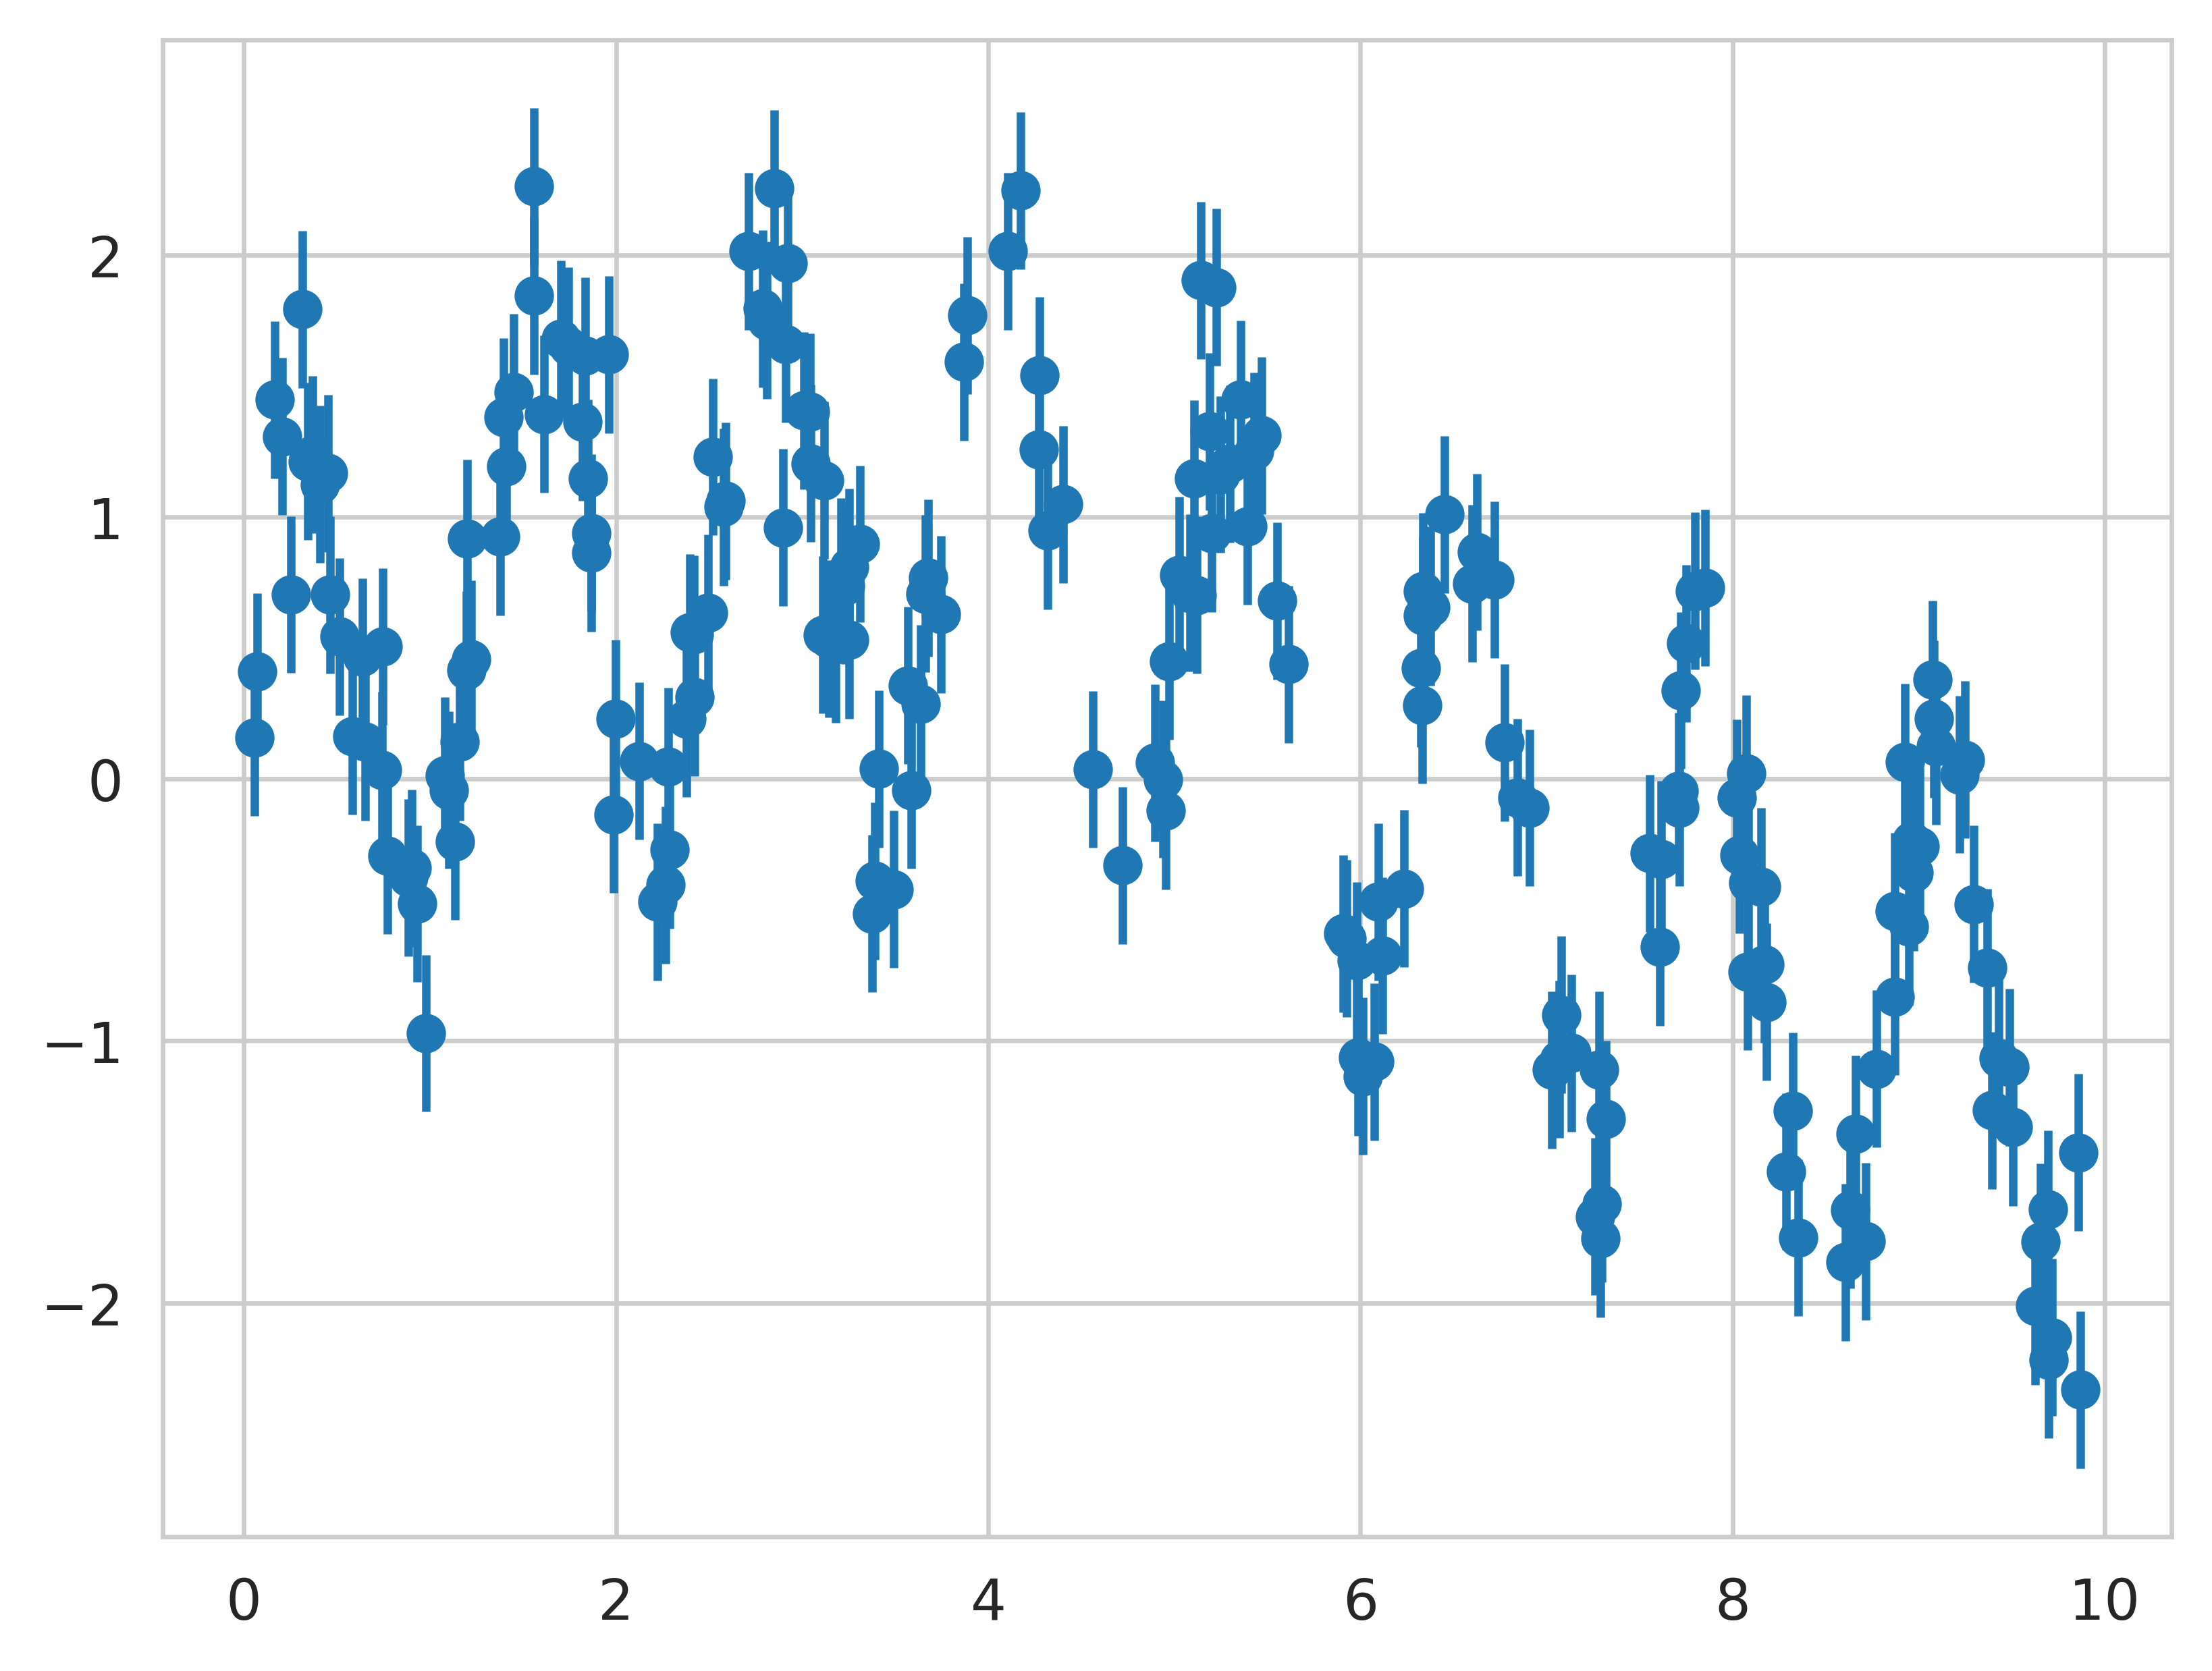

In [32]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

Usando el regresor Random Forest, podemos obtener la curva que mejor se ajusta a los datos de la siguiente manera (ver la figura que sigue a este texto):

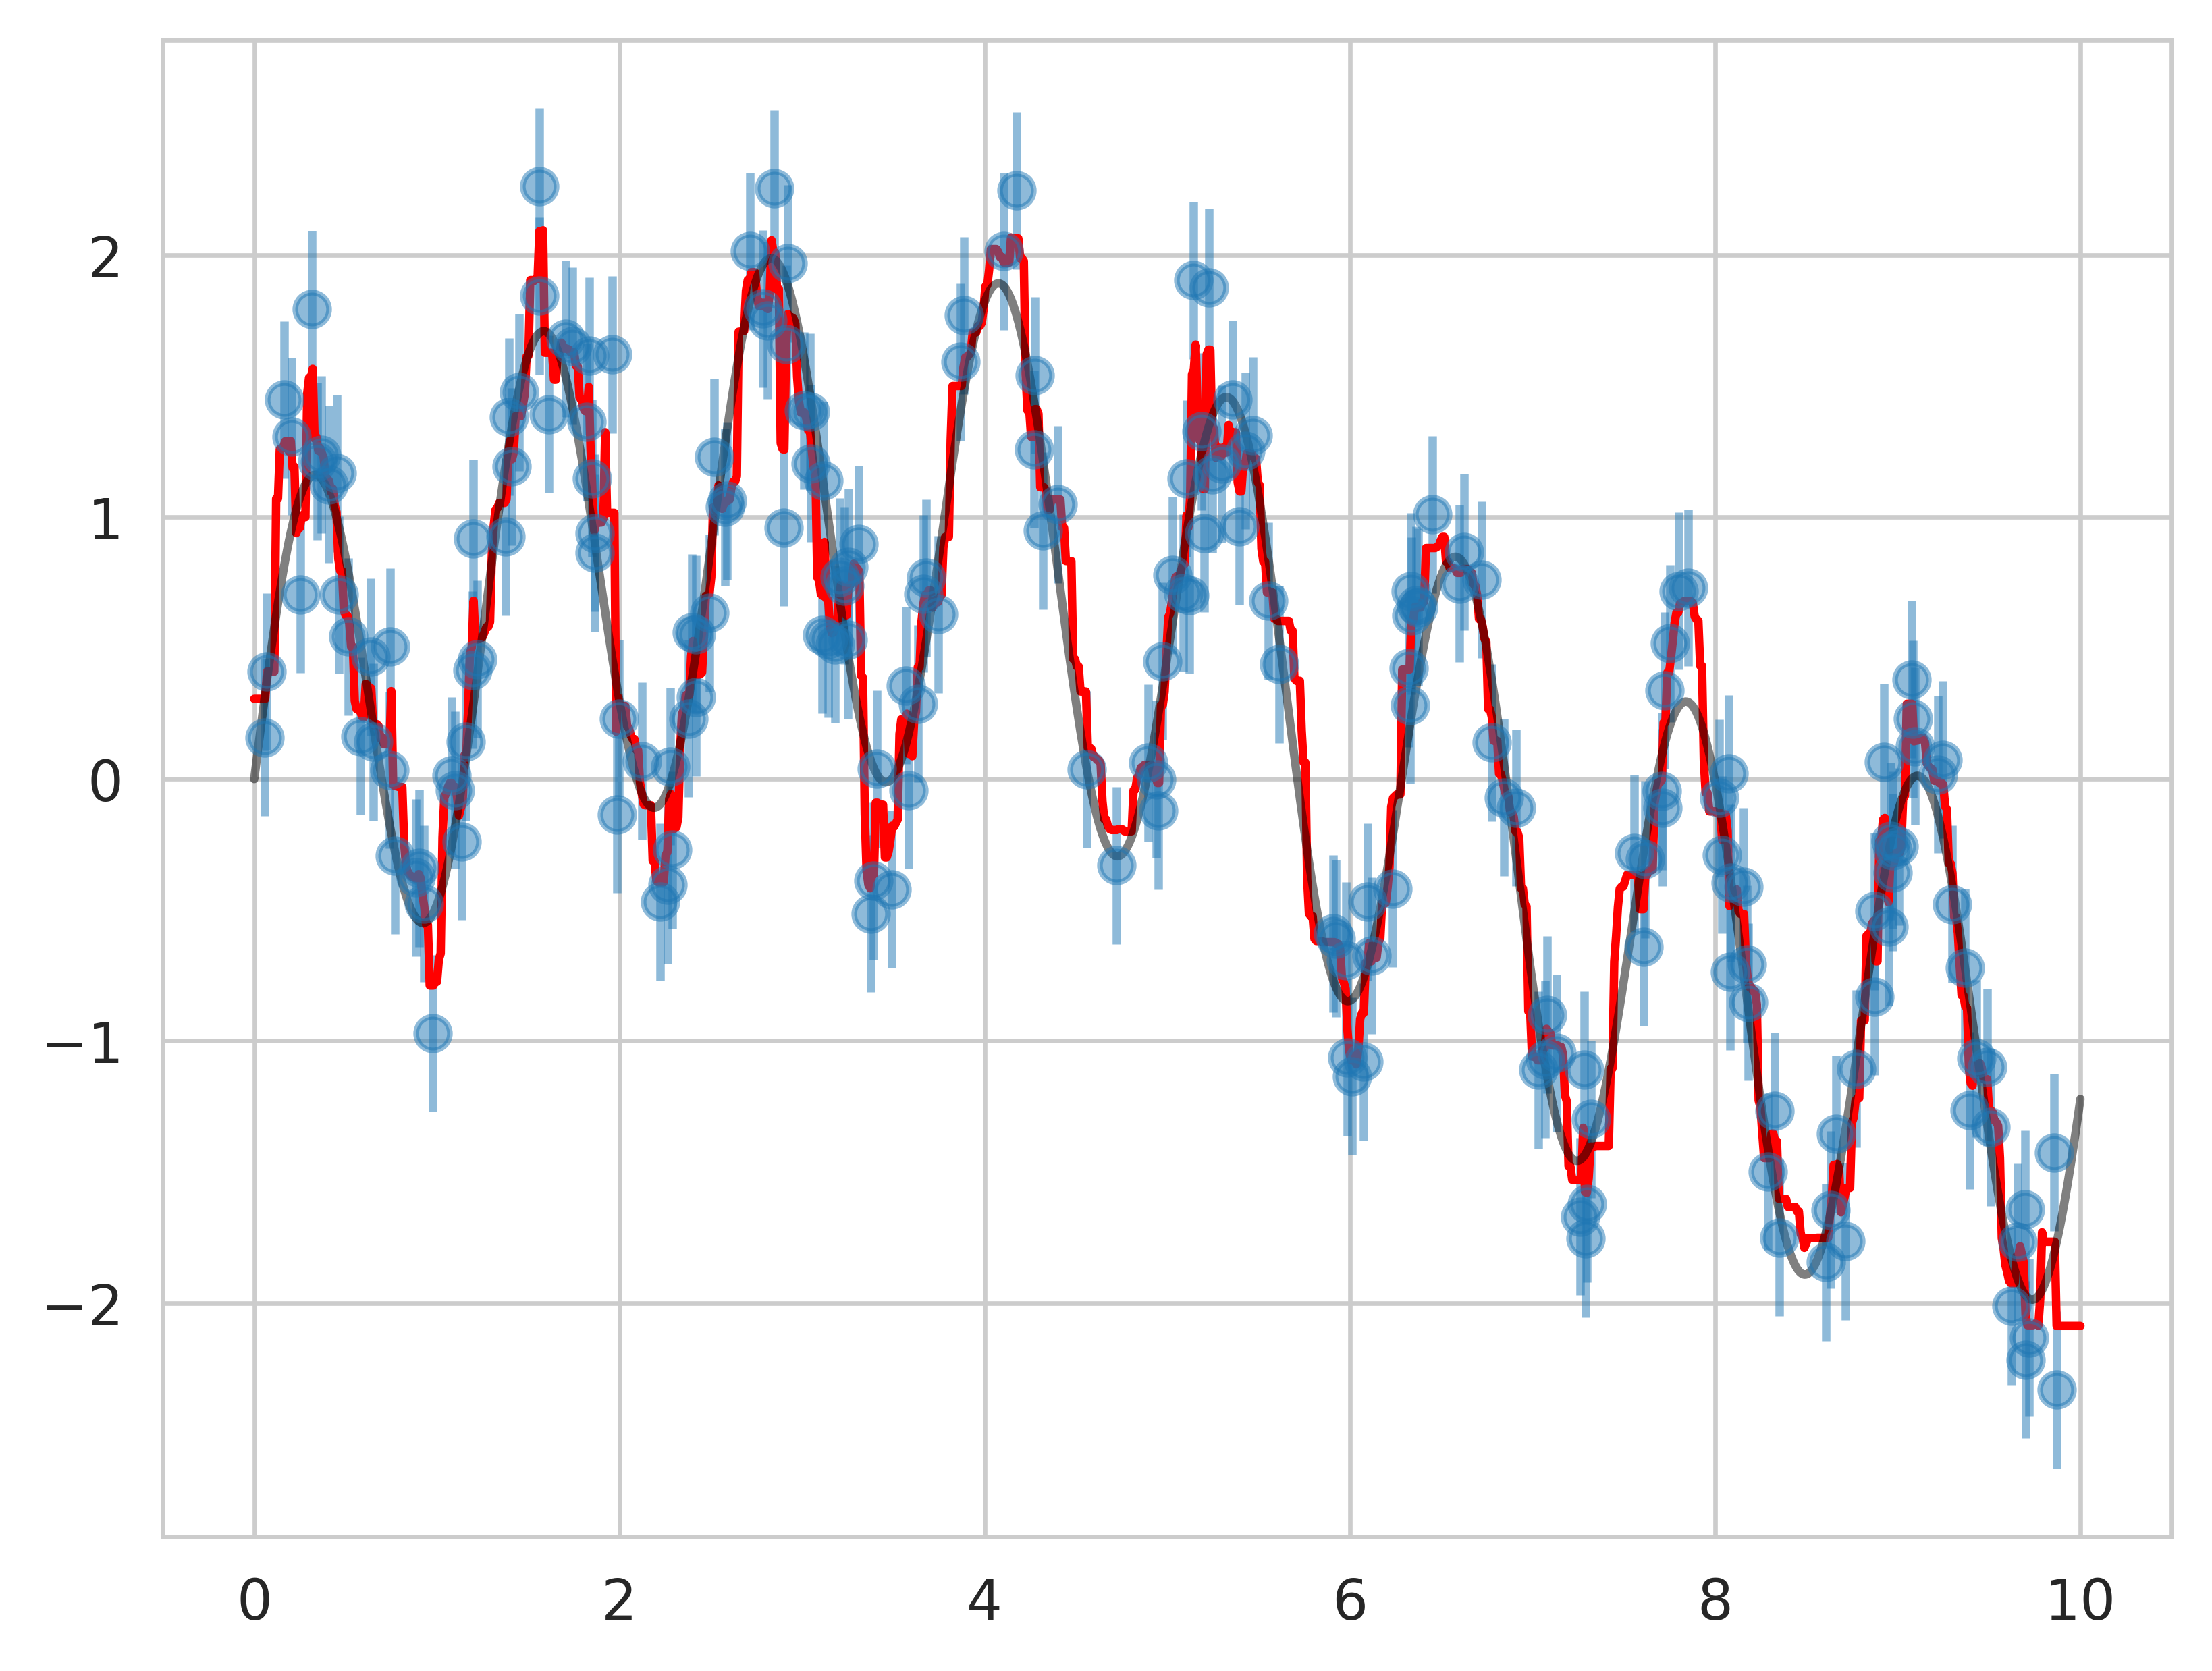

In [33]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

En la figura, la curva gris representa el modelo real (la función verdadera que generó los datos), mientras que la curva roja —más irregular y con pequeños picos— es el resultado del modelo generado por el Random Forest Regressor.

Lo interesante es que este modelo, al ser no paramétrico (es decir, no necesita una forma matemática fija), es lo suficientemente flexible como para adaptarse a datos con varios períodos u oscilaciones. Y lo hace sin necesidad de que nosotros le indiquemos explícitamente que la señal tiene múltiples frecuencias o que su comportamiento es complejo.

En pocas palabras:

➡️ El modelo verdadero es suave y continuo.
➡️ El random forest logra imitar esa forma bastante bien.
💡 Y todo esto sin decirle al modelo cómo debería ser esa función en teoría.

## Ejemplo: Random Forest para Clasificación de Dígitos

En el Capítulo 38 analizamos un ejemplo usando el conjunto de datos de dígitos que viene incluido en Scikit-Learn.
Ahora usaremos ese mismo dataset para ver cómo se puede aplicar el clasificador Random Forest en este tipo de problema.

In [34]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

Para recordar qué datos estamos analizando, vamos a visualizar los primeros puntos del conjunto de datos (ver la figura que sigue a continuación):

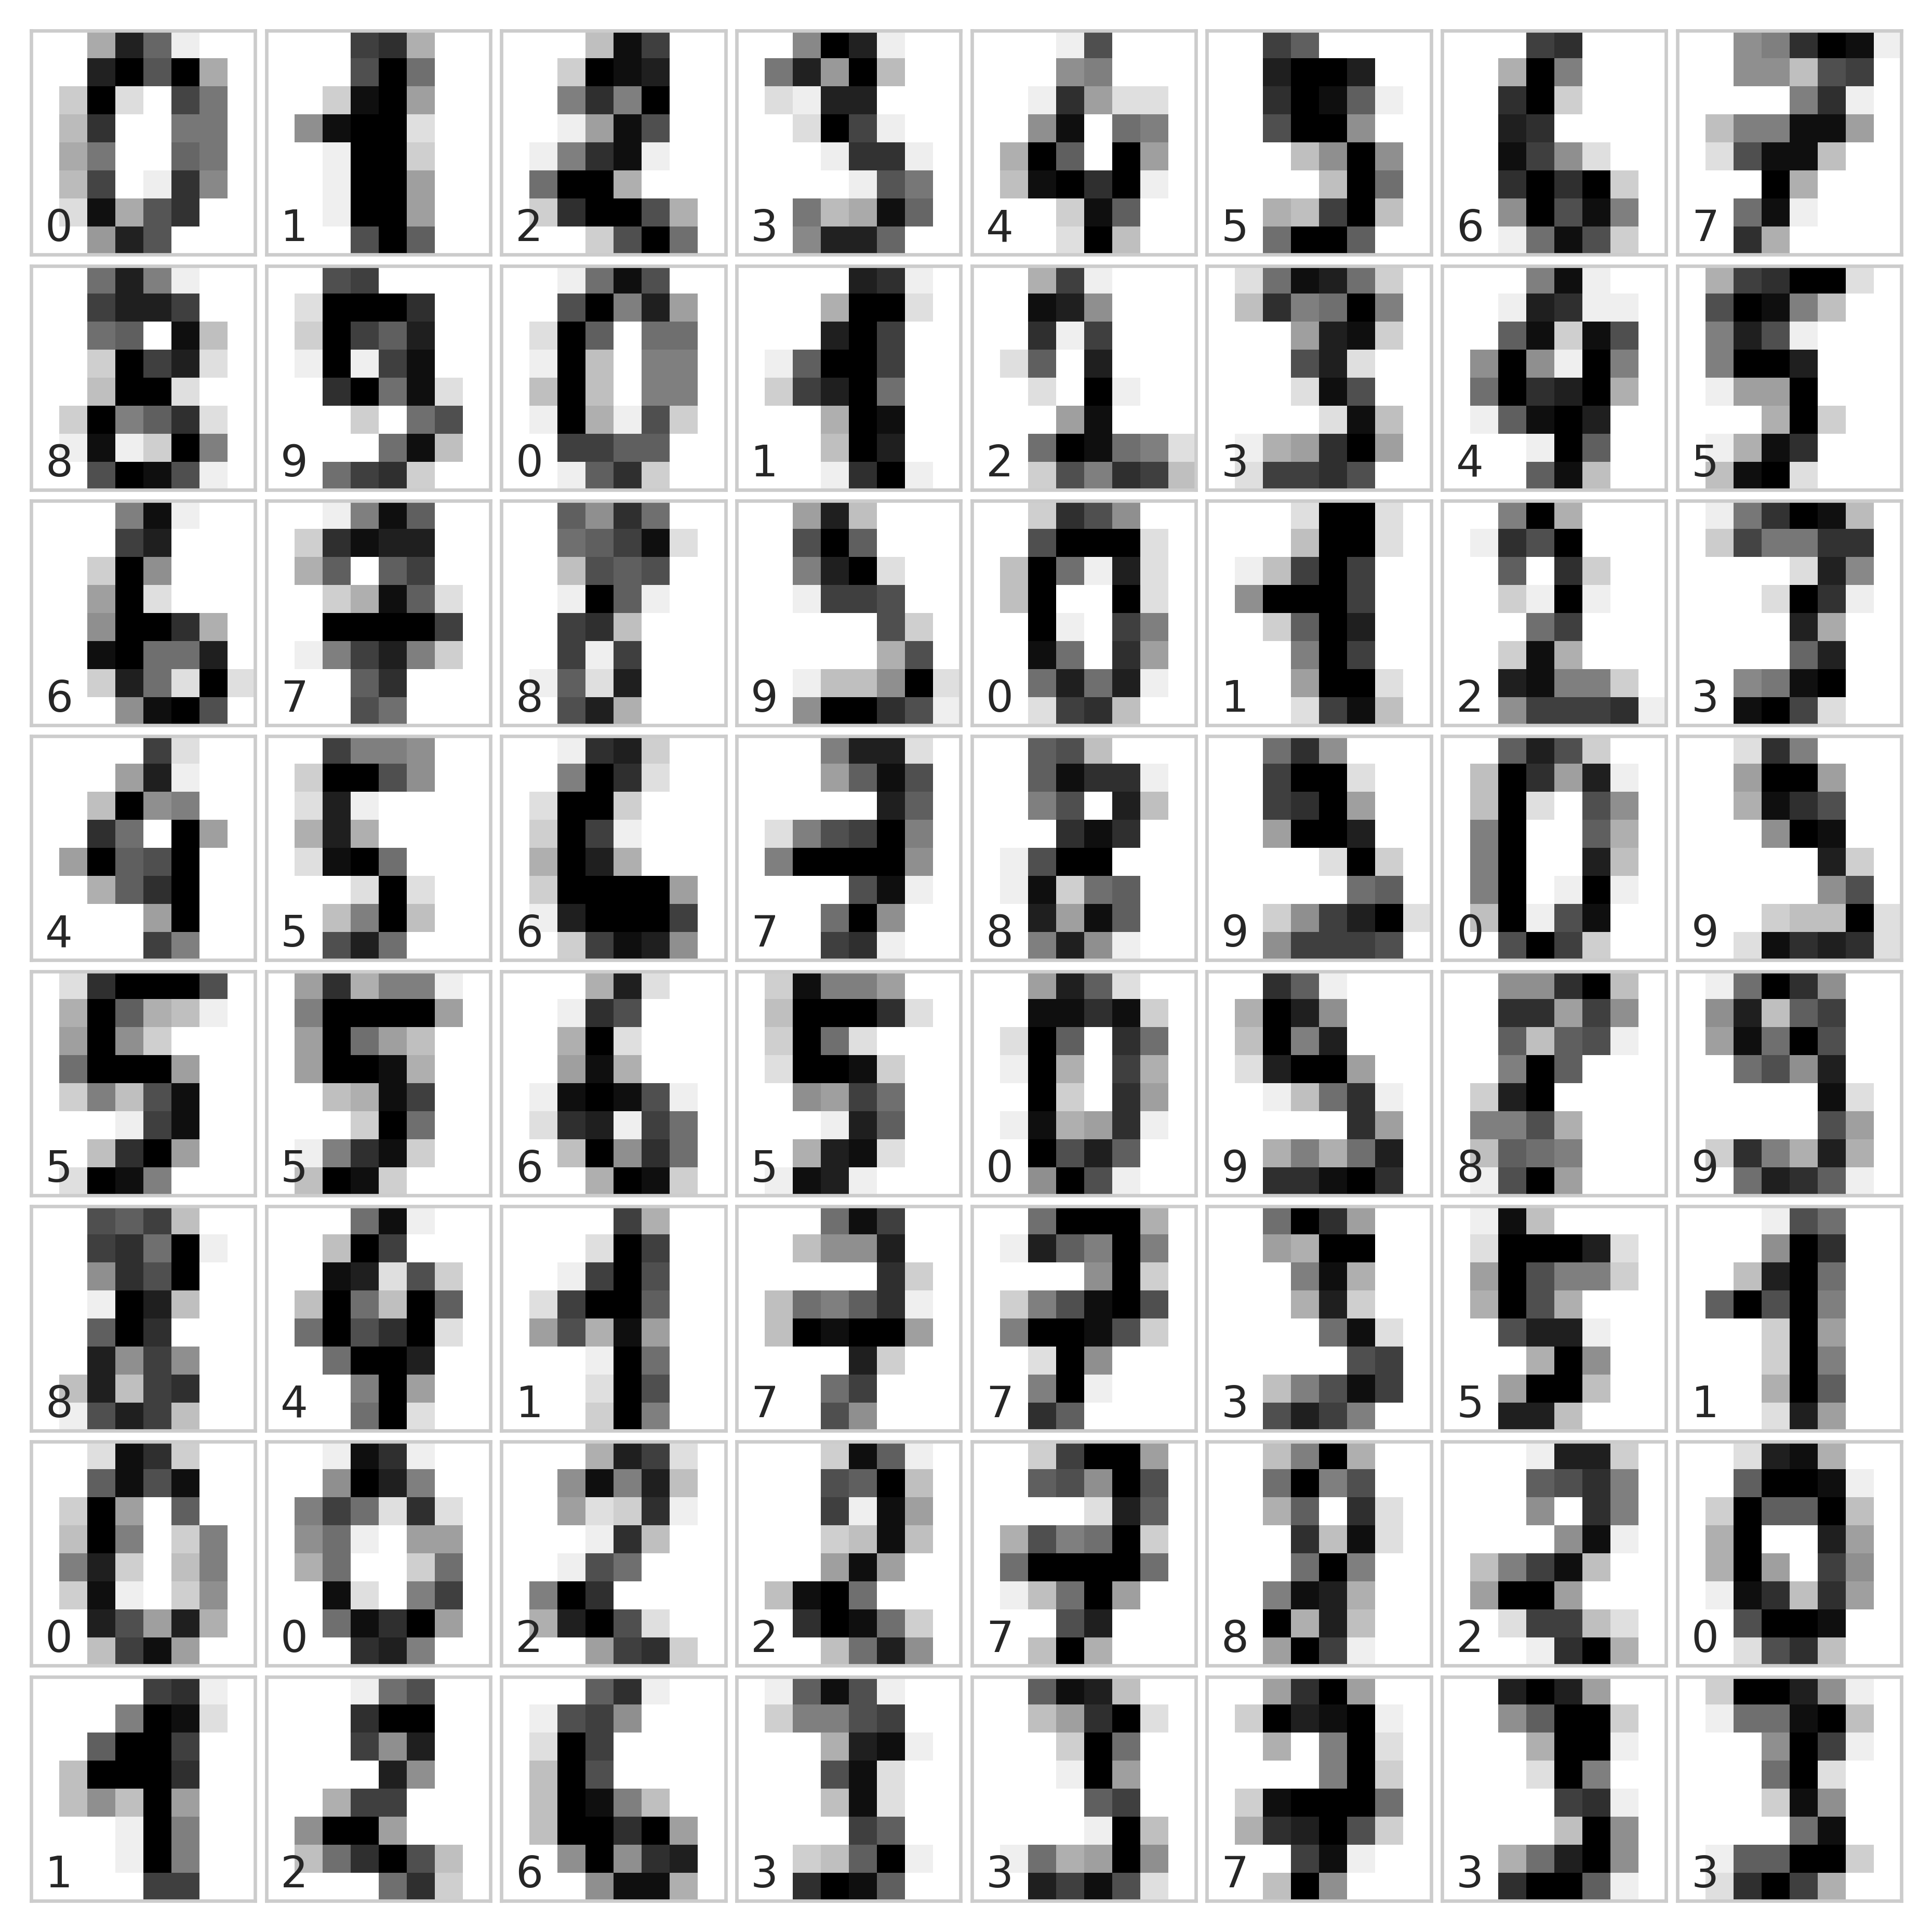

In [35]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')

    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

Podemos clasificar los dígitos usando un Random Forest de la siguiente manera:

In [36]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

Vamos a revisar el reporte de clasificación de este clasificador:

In [37]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.95      0.97        44
           2       0.95      1.00      0.98        42
           3       0.98      0.96      0.97        46
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.96      0.98      0.97        46

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



Y para tener una medida más visual del desempeño, vamos a graficar la matriz de confusión (ver la figura que sigue a continuación):

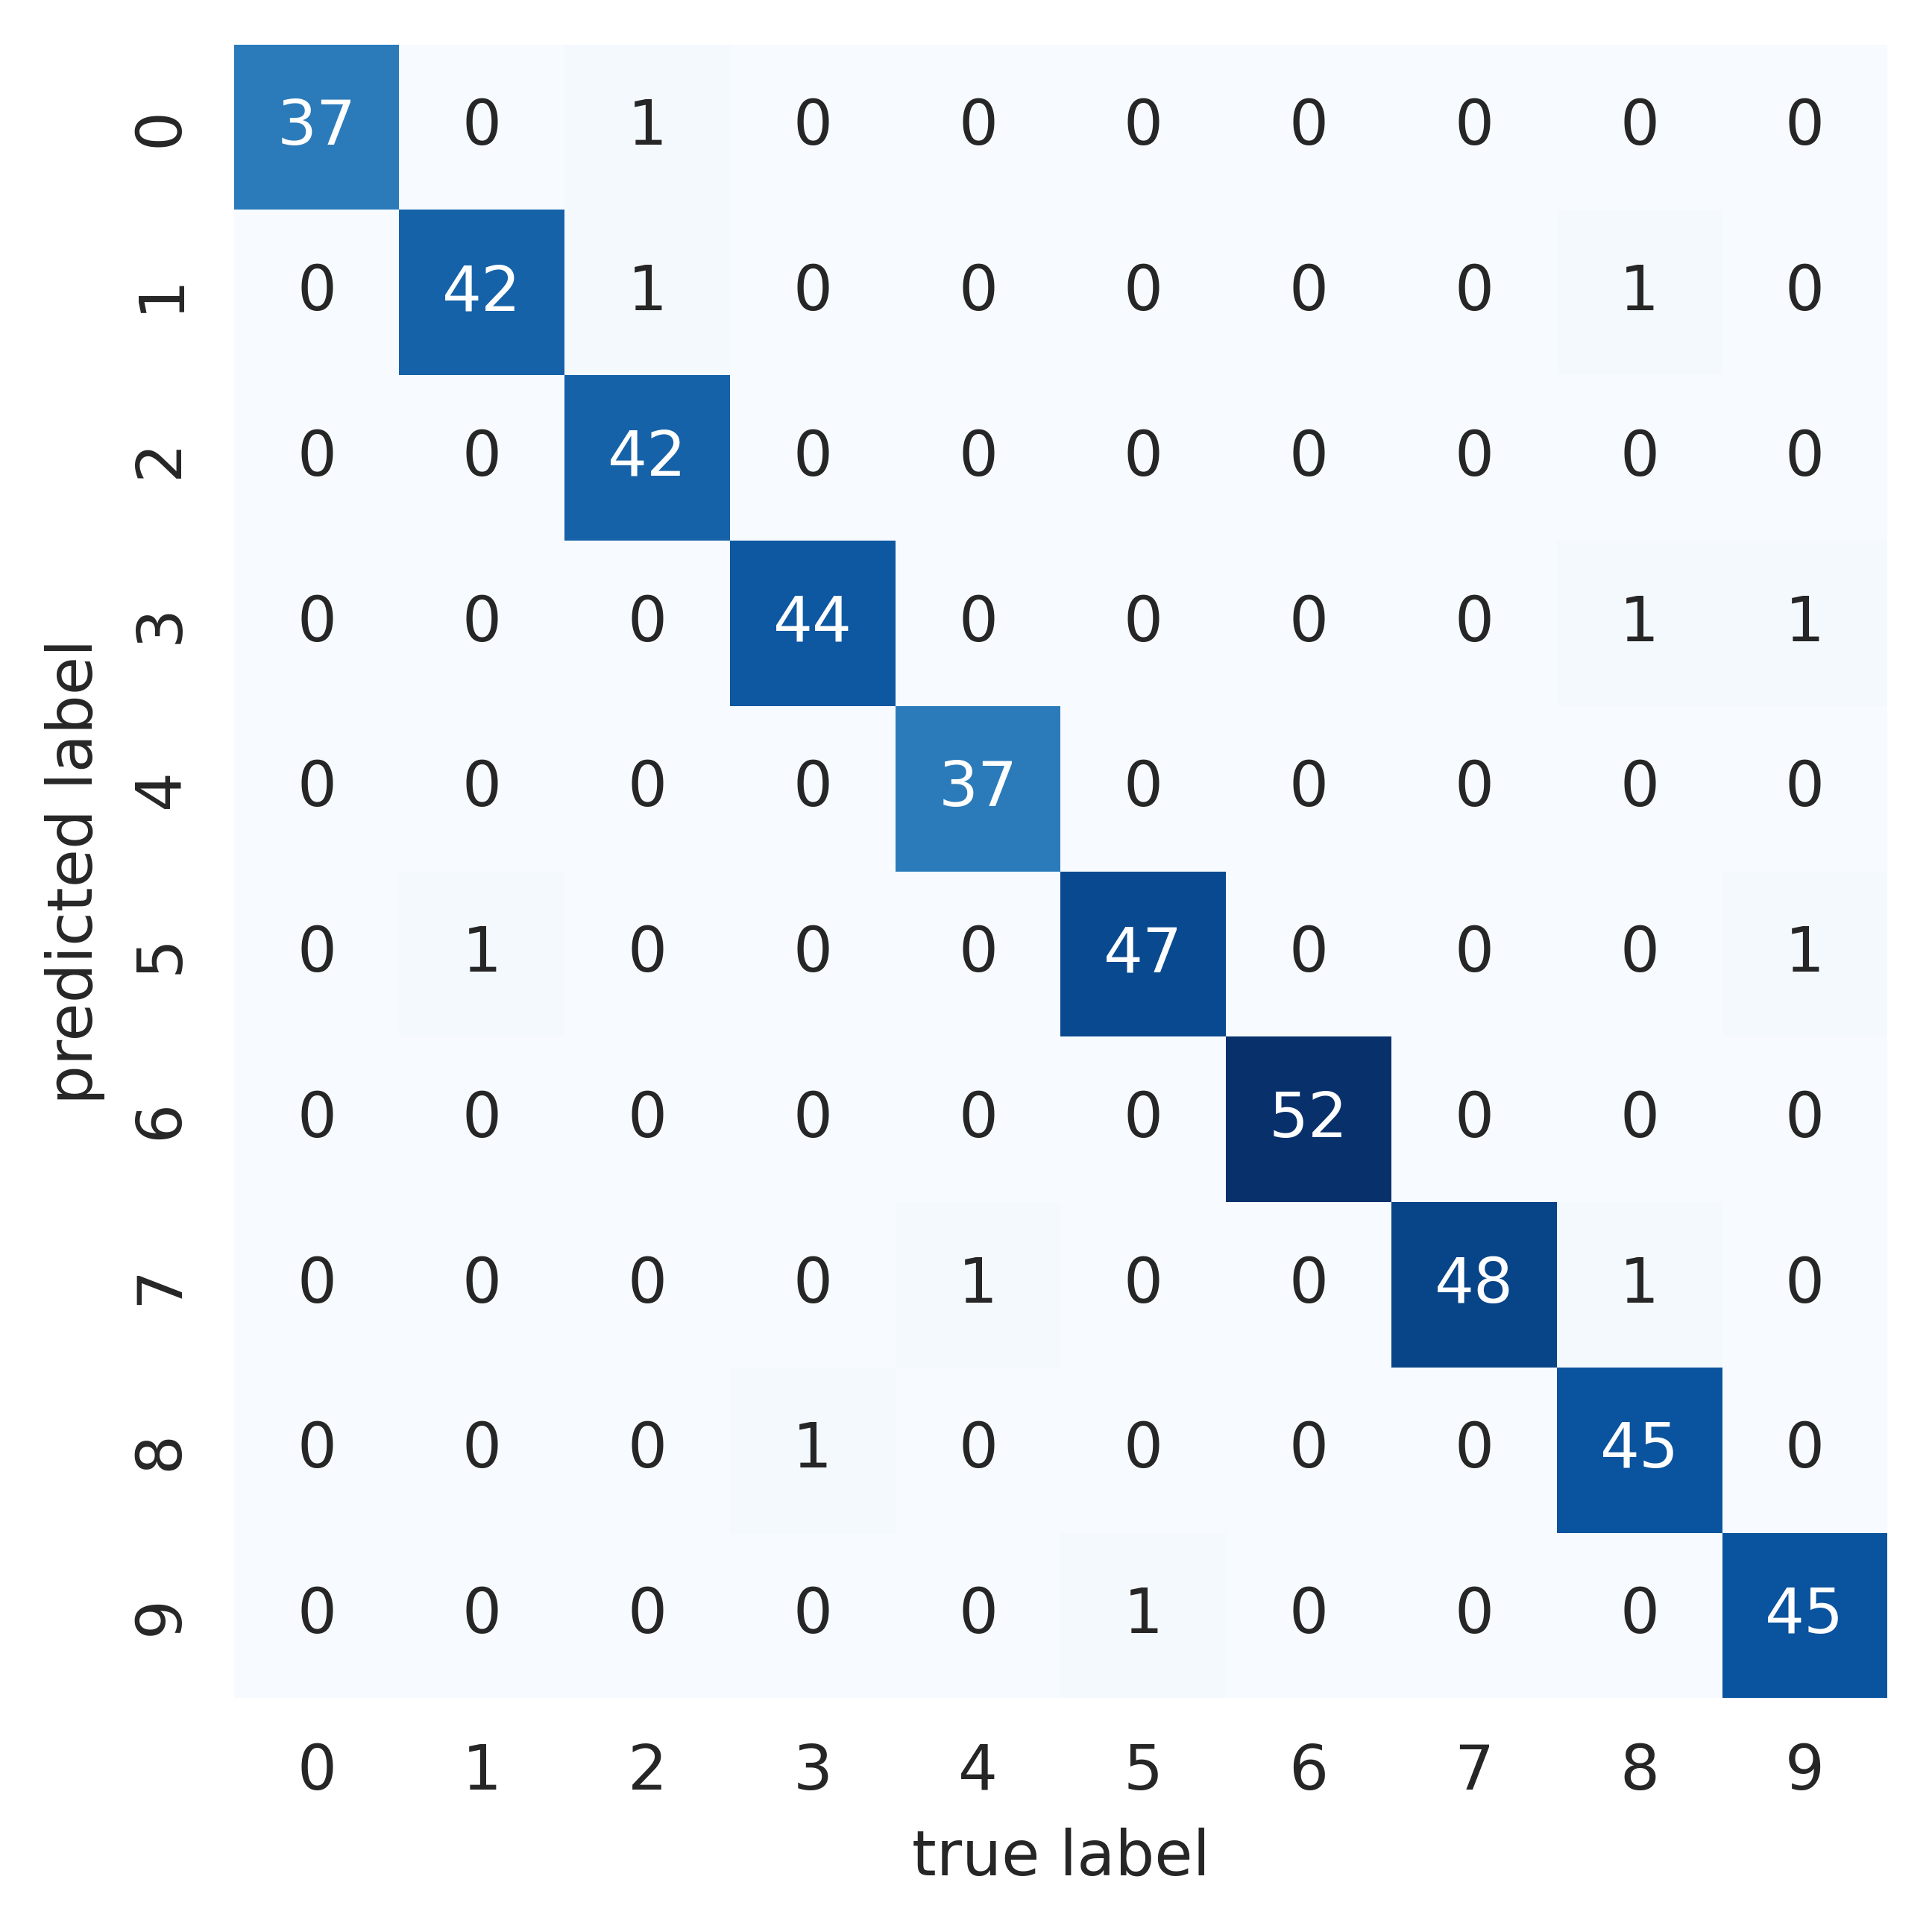

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cbar=False, cmap='Blues')
plt.xlabel('true label')
plt.ylabel('predicted label');

Encontramos que un Random Forest simple, sin ajustes finos, ya logra una clasificación bastante precisa del conjunto de datos de dígitos.

## Resumen

Este capítulo ofreció una breve introducción al concepto de estimadores en conjunto (ensemble estimators) y, en particular, al Random Forest, un conjunto de árboles de decisión aleatorizados.

Los Random Forests son un método poderoso con varias ventajas:

Tanto el entrenamiento como la predicción son muy rápidos, gracias a la simplicidad de los árboles de decisión que los componen. Además, estas tareas se pueden paralelizar fácilmente, porque cada árbol funciona de manera completamente independiente.

La existencia de múltiples árboles permite realizar una clasificación probabilística: el voto mayoritario entre los árboles nos da una estimación de la probabilidad (en Scikit-Learn se accede a esto con el método predict_proba).

Al ser un modelo no paramétrico, es extremadamente flexible y puede desempeñarse bien en tareas donde otros estimadores podrían subajustar (underfit) los datos.

Una desventaja principal de los Random Forests es que sus resultados no son fácilmente interpretables. Es decir, si quieres sacar conclusiones sobre el significado de cómo el modelo realiza la clasificación, quizás los Random Forests no sean la mejor opción.